## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# importing file module
from google.colab import files
# uploading files
uploaded = files.upload()

Saving AB_NYC_2019.csv to AB_NYC_2019.csv


In [3]:
#selecting columns
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]
#reading the dataset
df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
#filling missing values with 0
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [4]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [5]:
#importing train_test_split
from sklearn.model_selection import train_test_split
#splitting the dataset to train, validation and test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
#changing price column to numpy array
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values
#log transformation of price
y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)
# deleting price column from the dataset
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [7]:
#using  scikit learn for encoding categorical variables
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
# transforming train features
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
# transforming validation features
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
# transforming test features
test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [8]:
#importing libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [9]:
#training decision tree regressor
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [10]:

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [11]:
#importing libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
#training model
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
#predicting
y_pred = rf.predict(X_val)
#getting RMSE
msq = mse(y_val, y_pred)
RMSE = sqrt(msq)
print(RMSE)

0.460888788095762


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [12]:
scores = [] # creating empty list

for n in range(10, 201, 10): # iterating n_estimators
  #training model
  rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
  rf.fit(X_train, y_train)
  #predicting
  y_pred = rf.predict(X_val)
  #getting RMSE
  msq = mse(y_val, y_pred)
  RMSE = sqrt(msq)
    
  scores.append((n, RMSE))

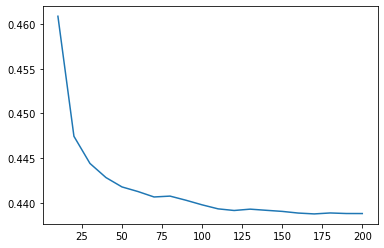

In [13]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'RMSE']) #creating a dataframe
plt.plot(df_scores.n_estimators, df_scores.RMSE) #plotting n_estimators against ROC

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [14]:
scores = [] #creating empty list

for d in [10, 15, 20, 25] : #iterating max depth
    for n in range(10, 201, 10):#iterating n_estimators
      #training model
      rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
      rf.fit(X_train, y_train)
      #predicting
      y_pred = rf.predict(X_val)
      #getting RMSE
      msq = mse(y_val, y_pred)
      RMSE = sqrt(msq)

      scores.append((d, n, RMSE))

In [15]:
columns = ['max_depth', 'n_estimators', 'RMSE']
#creating dataframe
df_scores = pd.DataFrame(scores, columns=columns)

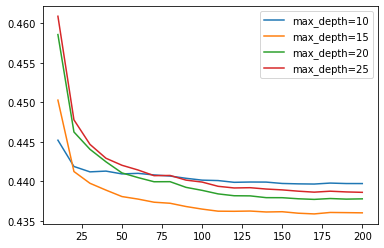

In [16]:
#plotting
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.RMSE,
             label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [17]:
#training model
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
#getting feature importance
rf.feature_importances_

array([7.65160846e-02, 3.09063525e-02, 1.52053975e-01, 1.53219337e-01,
       5.36452300e-02, 2.83822549e-04, 1.16611621e-03, 3.40167443e-02,
       1.15324234e-03, 1.18026952e-04, 4.35248857e-02, 5.24379349e-02,
       3.91896837e-01, 4.52061759e-03, 4.54079353e-03])

In [18]:
print(dict(zip(df_train.columns, rf.feature_importances_)))

{'neighbourhood_group': 0.07651608462923112, 'latitude': 0.030906352520589986, 'longitude': 0.15205397490899036, 'room_type': 0.15321933669623872, 'minimum_nights': 0.0536452299566982, 'number_of_reviews': 0.0002838225491492307, 'reviews_per_month': 0.0011661162111558155, 'calculated_host_listings_count': 0.03401674428986242, 'availability_365': 0.0011532423357895512}


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [19]:
# installing xgboost
!pip install xgboost

In [20]:
#importing xgboost
import xgboost as xgb
#creating Dmatrix for train and validation set
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [21]:
#creating watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [22]:
#training the model
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:3.02752	val-rmse:3.02415
[5]	train-rmse:0.674904	val-rmse:0.677523
[10]	train-rmse:0.439151	val-rmse:0.449813
[15]	train-rmse:0.423031	val-rmse:0.439126
[20]	train-rmse:0.417245	val-rmse:0.437226
[25]	train-rmse:0.412681	val-rmse:0.436174
[30]	train-rmse:0.407564	val-rmse:0.435124
[35]	train-rmse:0.404793	val-rmse:0.434324
[40]	train-rmse:0.401326	val-rmse:0.434602
[45]	train-rmse:0.399043	val-rmse:0.434132
[50]	train-rmse:0.395527	val-rmse:0.433357
[55]	train-rmse:0.391777	val-rmse:0.433642
[60]	train-rmse:0.388646	val-rmse:0.43327
[65]	train-rmse:0.383917	val-rmse:0.432713
[70]	train-rmse:0.380675	val-rmse:0.432784
[75]	train-rmse:0.377159	val-rmse:0.432945
[80]	train-rmse:0.374531	val-rmse:0.432804
[85]	train-rmse:0.37268	val-rmse:0.4331
[90]	train-rmse:0.370312	val-rmse:0.433563
[95]	train-rmse:0.366663	val-rmse:0.433719
[99]	train-rmse:0.36437	val-rmse:0.434066


Now change `eta` first to `0.1` and then to `0.01`

In [23]:
#eta=0.1
#training the model
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:3.87217	val-rmse:3.86889
[5]	train-rmse:2.31905	val-rmse:2.31689
[10]	train-rmse:1.41919	val-rmse:1.41798
[15]	train-rmse:0.912897	val-rmse:0.913599
[20]	train-rmse:0.645011	val-rmse:0.648887
[25]	train-rmse:0.517091	val-rmse:0.52394
[30]	train-rmse:0.461519	val-rmse:0.471089
[35]	train-rmse:0.438045	val-rmse:0.450283
[40]	train-rmse:0.427864	val-rmse:0.44178
[45]	train-rmse:0.422597	val-rmse:0.438206
[50]	train-rmse:0.418963	val-rmse:0.436207
[55]	train-rmse:0.416481	val-rmse:0.435422
[60]	train-rmse:0.414688	val-rmse:0.434822
[65]	train-rmse:0.412339	val-rmse:0.434327
[70]	train-rmse:0.410824	val-rmse:0.433942
[75]	train-rmse:0.409584	val-rmse:0.433725
[80]	train-rmse:0.407816	val-rmse:0.433406
[85]	train-rmse:0.406555	val-rmse:0.433194
[90]	train-rmse:0.405447	val-rmse:0.432963
[95]	train-rmse:0.404238	val-rmse:0.43287
[99]	train-rmse:0.404032	val-rmse:0.432873


In [24]:
#eta 0.01
#training the model
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:4.25336	val-rmse:4.2501
[5]	train-rmse:4.04779	val-rmse:4.04454
[10]	train-rmse:3.85242	val-rmse:3.84922
[15]	train-rmse:3.66674	val-rmse:3.66359
[20]	train-rmse:3.4903	val-rmse:3.48718
[25]	train-rmse:3.32263	val-rmse:3.31956
[30]	train-rmse:3.16332	val-rmse:3.16027
[35]	train-rmse:3.01196	val-rmse:3.00898
[40]	train-rmse:2.86817	val-rmse:2.86532
[45]	train-rmse:2.73158	val-rmse:2.72884
[50]	train-rmse:2.60185	val-rmse:2.59924
[55]	train-rmse:2.47865	val-rmse:2.47614
[60]	train-rmse:2.36167	val-rmse:2.35927
[65]	train-rmse:2.25061	val-rmse:2.24836
[70]	train-rmse:2.14519	val-rmse:2.14303
[75]	train-rmse:2.04515	val-rmse:2.04309
[80]	train-rmse:1.95021	val-rmse:1.94831
[85]	train-rmse:1.86016	val-rmse:1.85836
[90]	train-rmse:1.77473	val-rmse:1.77307
[95]	train-rmse:1.69373	val-rmse:1.69216
[99]	train-rmse:1.63197	val-rmse:1.63049


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

